In [1]:
# ## 1. Setup and Imports

# In[1]:
import os
import json
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from datetime import datetime
import logging
from collections import Counter, defaultdict
import gc
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All imports successful!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ All imports successful!
OpenCV version: 4.12.0
NumPy version: 2.2.6
Pandas version: 2.3.1


In [5]:
# ## 2. Configuration - UPDATE YOUR PATHS HERE

# 🚨 IMPORTANT: Update this path to match your dataset location
# Example: Change this to your actual path (on Windows, use raw string or double backslashes)
BASE_PATH = r"D:/DREAM_dataset"  # ✅ Update if needed

# ✅ Dataset configuration based on your folder structure
datasets_config = {
    'APTOS2019': f'{BASE_PATH}/APTOS 2019',
    'Diabetic_Retinopathy_V03': f'{BASE_PATH}/Diabetic Retinopathy_V03',
    'IDRiD': f'{BASE_PATH}/IDRiD',
    'Messidor2': f'{BASE_PATH}/Messidor 2',
    'SUSTech_SYSU': f'{BASE_PATH}/SUSTech_SYSU',
    'DeepDRiD': f'{BASE_PATH}/DeepDRiD/DeepDRiD/DR/Original'  # Note: nested path for DeepDRiD
}

# ✅ Optional: For quick testing, limit to fewer datasets
# datasets_config = {
#     'APTOS2019': f'{BASE_PATH}/APTOS 2019',
#     'DeepDRiD': f'{BASE_PATH}/DeepDRiD/DeepDRiD/DR/Original'
# }

# ✅ Other configuration settings
OUTPUT_DIR = 'quality_review'
RANDOM_SEED = 42
N_SAMPLES_PER_DATASET = 300  # Number of images to sample for characterization

# ✅ Print config to verify
print("Configuration set!")
print(f"Base path: {BASE_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Datasets to process: {list(datasets_config.keys())}")


Configuration set!
Base path: D:/DREAM_dataset
Output directory: quality_review
Datasets to process: ['APTOS2019', 'Diabetic_Retinopathy_V03', 'IDRiD', 'Messidor2', 'SUSTech_SYSU', 'DeepDRiD']


In [6]:
# ## 3. Validate Dataset Paths

# In[3]:
def validate_dataset_paths(datasets_config):
    """Validate that all dataset paths exist and contain DR class folders"""
    print("🔍 Validating dataset paths...")
    valid_datasets = {}
    
    for name, path in datasets_config.items():
        print(f"\nChecking {name}:")
        print(f"  Path: {path}")
        
        if not os.path.exists(path):
            print(f"  ❌ Path does not exist")
            continue
            
        # Check for DR class folders (0, 1, 2, 3, 4)
        dr_folders = []
        image_counts = {}
        
        try:
            for item in os.listdir(path):
                item_path = os.path.join(path, item)
                if os.path.isdir(item_path):
                    if item.isdigit() and int(item) in [0, 1, 2, 3, 4]:
                        dr_class = int(item)
                        dr_folders.append(dr_class)
                        
                        # Count images in this folder
                        image_extensions = ('.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.JPG', '.JPEG', '.PNG')
                        image_count = 0
                        for root, dirs, files in os.walk(item_path):
                            for file in files:
                                if file.lower().endswith(image_extensions):
                                    image_count += 1
                        image_counts[dr_class] = image_count
            
            if dr_folders:
                dr_folders.sort()
                total_images = sum(image_counts.values())
                print(f"  ✅ Found DR classes: {dr_folders}")
                print(f"  📊 Image counts per class:")
                dr_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
                for dr_class in dr_folders:
                    dr_name = dr_names[dr_class] if 0 <= dr_class < 5 else f'Class {dr_class}'
                    print(f"     {dr_name} (Class {dr_class}): {image_counts[dr_class]:,} images")
                print(f"  📈 Total images: {total_images:,}")
                
                if total_images > 0:
                    valid_datasets[name] = path
                else:
                    print(f"  ⚠️  No images found in DR class folders")
            else:
                print(f"  ❌ No DR class folders (0,1,2,3,4) found")
                print(f"     Available folders: {[item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item))]}")
                
        except Exception as e:
            print(f"  ❌ Error accessing path: {e}")
    
    print(f"\n📋 Summary: {len(valid_datasets)}/{len(datasets_config)} datasets are valid")
    return valid_datasets

# Run validation
valid_datasets = validate_dataset_paths(datasets_config)

if not valid_datasets:
    print("\n🚨 No valid datasets found!")
    print("\n🔧 Troubleshooting:")
    print("1. Update BASE_PATH in cell [2] to your actual dataset location")
    print("2. Ensure your datasets have folders named 0, 1, 2, 3, 4 containing images")
    print("3. For DeepDRiD, make sure the path points to DeepDRiD/DR/Original/")
else:
    print(f"\n✅ Ready to proceed with {len(valid_datasets)} datasets!")

🔍 Validating dataset paths...

Checking APTOS2019:
  Path: D:/DREAM_dataset/APTOS 2019
  ✅ Found DR classes: [0, 1, 2, 3, 4]
  📊 Image counts per class:
     No DR (Class 0): 1,805 images
     Mild DR (Class 1): 370 images
     Moderate DR (Class 2): 999 images
     Severe DR (Class 3): 193 images
     Proliferative DR (Class 4): 295 images
  📈 Total images: 3,662

Checking Diabetic_Retinopathy_V03:
  Path: D:/DREAM_dataset/Diabetic Retinopathy_V03
  ✅ Found DR classes: [0, 1, 2, 3, 4]
  📊 Image counts per class:
     No DR (Class 0): 711 images
     Mild DR (Class 1): 6 images
     Moderate DR (Class 2): 110 images
     Severe DR (Class 3): 349 images
     Proliferative DR (Class 4): 261 images
  📈 Total images: 1,437

Checking IDRiD:
  Path: D:/DREAM_dataset/IDRiD
  ✅ Found DR classes: [0, 1, 2, 3, 4]
  📊 Image counts per class:
     No DR (Class 0): 168 images
     Mild DR (Class 1): 25 images
     Moderate DR (Class 2): 168 images
     Severe DR (Class 3): 93 images
     Proliferat

In [7]:
# ## 4. Quality Identifier Class Definition

# In[4]:
class QualityIdentifier:
    def __init__(self, output_dir='quality_review', random_seed=42):
        self.output_dir = output_dir
        self.dataset_profiles = {}
        self.identification_results = []
        self.random_seed = random_seed
        
        # Set random seed for reproducibility
        np.random.seed(random_seed)
        
        # Create output directories
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(f'{output_dir}/sample_images', exist_ok=True)
        os.makedirs(f'{output_dir}/flagged_samples', exist_ok=True)
        
        logger.info(f"Quality identification output directory: {output_dir}")
    
    def extract_dr_label_from_path(self, image_path):
        """Extract DR severity from path - optimized for your dataset structure"""
        parts = image_path.split(os.sep)
        
        # Method 1: Check for folder names that are DR classes (most common in your structure)
        for part in parts:
            if part.isdigit() and int(part) in [0, 1, 2, 3, 4]:
                return int(part)
        
        # Method 2: Check for common DR folder naming patterns
        dr_patterns = {
            'no_dr': 0, 'normal': 0, 'grade_0': 0, 'class_0': 0,
            'mild': 1, 'grade_1': 1, 'class_1': 1,
            'moderate': 2, 'grade_2': 2, 'class_2': 2,
            'severe': 3, 'grade_3': 3, 'class_3': 3,
            'proliferative': 4, 'grade_4': 4, 'class_4': 4
        }
        
        for part in parts:
            part_lower = part.lower()
            if part_lower in dr_patterns:
                return dr_patterns[part_lower]
        
        return None
    
    def sample_images_strategically(self, dataset_path, n_samples):
        """Sample images from all DR classes proportionally"""
        all_images = []
        class_images = {0: [], 1: [], 2: [], 3: [], 4: []}
        
        print(f"  🔍 Scanning directory structure...")
        
        # Collect all images by class
        image_extensions = ('.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.JPG', '.JPEG', '.PNG')
        
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.lower().endswith(image_extensions):
                    image_path = os.path.join(root, file)
                    dr_class = self.extract_dr_label_from_path(image_path)
                    if dr_class is not None:
                        class_images[dr_class].append(image_path)
        
        # Log class distribution
        for dr_class, images in class_images.items():
            dr_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
            dr_name = dr_names[dr_class] if 0 <= dr_class < 5 else f'Class {dr_class}'
            if images:
                print(f"    {dr_name}: {len(images)} images")
        
        # Sample proportionally from each class
        sampled_images = []
        total_available = sum(len(images) for images in class_images.values())
        
        if total_available == 0:
            print("    ⚠️  No images found with valid DR labels")
            return []
        
        samples_per_class = max(1, n_samples // 5)
        
        for dr_class, images in class_images.items():
            if images:
                n_class_samples = min(samples_per_class, len(images))
                sampled = np.random.choice(images, n_class_samples, replace=False)
                sampled_images.extend(sampled)
        
        print(f"  📊 Selected {len(sampled_images)} stratified samples")
        return sampled_images
    
    def calculate_entropy(self, image):
        """Calculate Shannon entropy"""
        try:
            hist = cv2.calcHist([image], [0], None, [256], [0, 256])
            hist = hist.flatten()
            hist = hist[hist > 0]
            if len(hist) == 0:
                return 0.0
            prob = hist / hist.sum()
            return float(-np.sum(prob * np.log2(prob)))
        except Exception:
            return 0.0
    
    def assess_vessel_visibility(self, image):
        """Quick vessel visibility assessment"""
        try:
            green = image[:, :, 1]
            # Simple vessel enhancement filter
            kernel = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]], dtype=np.float32)
            filtered = cv2.filter2D(green, cv2.CV_32F, kernel)
            vessel_pixels = np.sum(filtered > np.percentile(filtered, 98))
            total_pixels = filtered.shape[0] * filtered.shape[1]
            return float(vessel_pixels / max(total_pixels, 1))
        except Exception:
            return 0.0
    
    def assess_optic_disc_visibility(self, image):
        """Quick optic disc visibility assessment"""
        try:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            bright_pixels = np.sum(gray > np.percentile(gray, 95))
            total_pixels = gray.shape[0] * gray.shape[1]
            return float(bright_pixels / max(total_pixels, 1))
        except Exception:
            return 0.0
    
    def assess_illumination_uniformity(self, gray):
        """Assess illumination uniformity across image"""
        try:
            h, w = gray.shape
            regions = []
            
            # Divide into 3x3 grid
            for i in range(3):
                for j in range(3):
                    start_y, end_y = i * h // 3, (i + 1) * h // 3
                    start_x, end_x = j * w // 3, (j + 1) * w // 3
                    region = gray[start_y:end_y, start_x:end_x]
                    regions.append(np.mean(region))
            
            mean_intensity = np.mean(regions)
            if mean_intensity > 0:
                cv_score = np.std(regions) / mean_intensity
                return float(max(0, 1 - cv_score))
            return 0.0
        except Exception:
            return 0.0
    
    def detect_black_borders(self, gray):
        """Detect presence of black borders"""
        try:
            h, w = gray.shape
            border_thickness = min(50, h//10, w//10)
            
            if border_thickness < 1:
                return False
            
            # Check borders
            top_border = np.mean(gray[:border_thickness, :])
            bottom_border = np.mean(gray[-border_thickness:, :])
            left_border = np.mean(gray[:, :border_thickness])
            right_border = np.mean(gray[:, -border_thickness:])
            
            # Consider it has black borders if any border is very dark
            black_threshold = 30
            return any(border < black_threshold for border in [top_border, bottom_border, left_border, right_border])
        except Exception:
            return False
    
    def detect_extreme_pixels(self, gray):
        """Detect percentage of extremely bright or dark pixels"""
        try:
            very_dark = np.sum(gray < 10)
            very_bright = np.sum(gray > 245)
            total_pixels = gray.shape[0] * gray.shape[1]
            return float((very_dark + very_bright) / max(total_pixels, 1))
        except Exception:
            return 0.0
    
    def assess_motion_blur(self, gray):
        """Assess motion blur using gradient analysis"""
        try:
            grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            magnitude = np.sqrt(grad_x**2 + grad_y**2)
            return float(np.mean(magnitude))
        except Exception:
            return 0.0
    
    def analyze_single_image(self, image_path):
        """Analyze single image characteristics"""
        try:
            image = cv2.imread(image_path)
            if image is None:
                return None
            
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            h, w = image.shape[:2]
            
            # Check for minimum size requirements
            if h < 50 or w < 50:
                return None
            
            characteristics = {
                'image_path': image_path,
                'filename': os.path.basename(image_path),
                'resolution': (w, h),
                'file_size_mb': os.path.getsize(image_path) / (1024*1024),
                
                # Basic quality metrics
                'brightness': float(np.mean(image)),
                'contrast': float(np.std(image)),
                'sharpness': float(cv2.Laplacian(gray, cv2.CV_64F).var()),
                'entropy': self.calculate_entropy(gray),
                
                # Color analysis (important for different cameras/ethnicities)
                'red_mean': float(np.mean(image[:,:,2])),
                'green_mean': float(np.mean(image[:,:,1])),
                'blue_mean': float(np.mean(image[:,:,0])),
                'color_balance': float(np.std([np.mean(image[:,:,0]), np.mean(image[:,:,1]), np.mean(image[:,:,2])])),
                
                # Medical structure visibility
                'vessel_visibility': self.assess_vessel_visibility(image),
                'optic_disc_visibility': self.assess_optic_disc_visibility(image),
                'illumination_uniformity': self.assess_illumination_uniformity(gray),
                
                # Potential artifact detection
                'has_black_borders': self.detect_black_borders(gray),
                'extreme_brightness_pixels': self.detect_extreme_pixels(gray),
                'motion_blur_score': self.assess_motion_blur(gray)
            }
            
            return characteristics
            
        except Exception as e:
            return None

print("✅ QualityIdentifier class defined successfully!")

✅ QualityIdentifier class defined successfully!


In [10]:
# ## 5. Initialize Quality Identifier

# In[5]:
# Only proceed if we have valid datasets
if valid_datasets:
    identifier = QualityIdentifier(
        output_dir=OUTPUT_DIR, 
        random_seed=RANDOM_SEED
    )
    print("✅ QualityIdentifier initialized!")
    print(f"📁 Output directory: {OUTPUT_DIR}")
else:
    print("❌ Cannot initialize - no valid datasets found")

2025-08-06 05:45:20,529 - INFO - Quality identification output directory: quality_review


✅ QualityIdentifier initialized!
📁 Output directory: quality_review


In [11]:
# In[6]:
def characterize_dataset(identifier, dataset_path, dataset_name, n_samples=300):
    """Characterize dataset properties for adaptive thresholding"""
    print(f"🔬 Characterizing {dataset_name}...")
    
    # Sample images strategically
    sample_images = identifier.sample_images_strategically(dataset_path, n_samples)
    
    if not sample_images:
        print(f"  ❌ No images found in {dataset_path}")
        return None
    
    print(f"  🧪 Analyzing {len(sample_images)} sample images...")
    
    # Analyze characteristics with progress updates
    characteristics = []
    for i, img_path in enumerate(sample_images):
        if i % 50 == 0 and i > 0:
            print(f"    Progress: {i}/{len(sample_images)} ({i/len(sample_images)*100:.1f}%)")
        
        char = identifier.analyze_single_image(img_path)
        if char:
            characteristics.append(char)
        
        # Memory management
        if i % 100 == 0:
            gc.collect()
    
    if not characteristics:
        print(f"  ❌ No valid characteristics extracted from {dataset_name}")
        return None
    
    print(f"  ✅ Analyzed {len(characteristics)} valid images")
    
    # Calculate dataset profile
    profile = calculate_dataset_profile(dataset_name, characteristics)
    
    # Save sample images for review
    save_sample_images(identifier, sample_images[:20], dataset_name)
    
    return profile

def calculate_dataset_profile(dataset_name, characteristics):
    """Calculate comprehensive dataset profile"""
    profile = {
        'dataset_name': dataset_name,
        'analysis_date': datetime.now().isoformat(),
        'n_samples_analyzed': len(characteristics),
        'characteristics_stats': {},
        'adaptive_thresholds': {}
    }
    
    # Calculate statistics for each characteristic
    numeric_keys = [key for key in characteristics[0].keys() 
                   if key not in ['image_path', 'filename', 'resolution']]
    
    for key in numeric_keys:
        # Get raw values, filtering out None
        raw_values = [char[key] for char in characteristics if char[key] is not None]
        
        # Convert values, handling booleans and ensuring numeric types
        values = []
        for val in raw_values:
            if isinstance(val, bool):
                values.append(float(val))  # True -> 1.0, False -> 0.0
            elif isinstance(val, (int, float)):
                values.append(float(val))
            else:
                # Skip non-numeric, non-boolean values
                continue
        
        if values:
            profile['characteristics_stats'][key] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'min': float(np.min(values)),
                'max': float(np.max(values)),
                'percentiles': {
                    '5': float(np.percentile(values, 5)),
                    '10': float(np.percentile(values, 10)),
                    '25': float(np.percentile(values, 25)),
                    '50': float(np.percentile(values, 50)),
                    '75': float(np.percentile(values, 75)),
                    '90': float(np.percentile(values, 90)),
                    '95': float(np.percentile(values, 95))
                }
            }
    
    # Calculate adaptive removal thresholds
    removal_percentiles = {
        0: 15,  # No DR - consider removing worst 15%
        1: 12,  # Mild DR - consider removing worst 12%
        2: 10,  # Moderate DR - consider removing worst 10%
        3: 8,   # Severe DR - consider removing worst 8%
        4: 5    # Proliferative DR - consider removing worst 5%
    }
    
    # Calculate combined quality scores for threshold calculation
    quality_scores = []
    for char in characteristics:
        # Safely get and normalize metrics with error handling
        try:
            # Convert boolean values to float if needed
            brightness = float(char['brightness']) if char['brightness'] is not None else 127.5
            contrast = float(char['contrast']) if char['contrast'] is not None else 50.0
            sharpness = float(char['sharpness']) if char['sharpness'] is not None else 500.0
            entropy = float(char['entropy']) if char['entropy'] is not None else 4.0
            illumination_uniformity = float(char['illumination_uniformity']) if char['illumination_uniformity'] is not None else 0.5
            vessel_visibility = float(char['vessel_visibility']) if char['vessel_visibility'] is not None else 0.1
            optic_disc_visibility = float(char['optic_disc_visibility']) if char['optic_disc_visibility'] is not None else 0.1
            
            # Normalize metrics
            brightness_norm = min(1.0, max(0.0, brightness / 255.0))
            contrast_norm = min(1.0, max(0.0, contrast / 100.0))
            sharpness_norm = min(1.0, max(0.0, sharpness / 1000.0))
            entropy_norm = min(1.0, max(0.0, entropy / 8.0))
            
            basic_quality = np.mean([brightness_norm, contrast_norm, sharpness_norm, entropy_norm])
            
            medical_quality = np.mean([
                illumination_uniformity,
                min(1.0, vessel_visibility * 10),
                min(1.0, optic_disc_visibility * 10)
            ])
            
            combined_quality = 0.3 * basic_quality + 0.7 * medical_quality
            quality_scores.append(combined_quality)
        except (TypeError, ValueError) as e:
            # If there's an error with any characteristic, use a default quality score
            print(f"    ⚠️  Warning: Error calculating quality score for image, using default: {e}")
            quality_scores.append(0.3)  # Default low quality score
    
    # Set percentile-based thresholds
    for dr_severity, percentile in removal_percentiles.items():
        try:
            threshold = np.percentile(quality_scores, percentile) if quality_scores else 0.3
            profile['adaptive_thresholds'][dr_severity] = float(threshold)
        except Exception as e:
            print(f"    ⚠️  Warning: Error calculating threshold for DR severity {dr_severity}: {e}")
            profile['adaptive_thresholds'][dr_severity] = 0.3  # Default threshold
    
    return profile

def save_sample_images(identifier, sample_paths, dataset_name):
    """Save sample images for visual review"""
    sample_dir = f'{identifier.output_dir}/sample_images/{dataset_name}'
    os.makedirs(sample_dir, exist_ok=True)
    
    copied_count = 0
    for i, img_path in enumerate(sample_paths):
        try:
            dst_path = f'{sample_dir}/sample_{i:02d}_{os.path.basename(img_path)}'
            shutil.copy2(img_path, dst_path)
            copied_count += 1
        except Exception as e:
            print(f"    ⚠️  Error copying sample {img_path}: {e}")
    
    print(f"  📸 Saved {copied_count} sample images to {sample_dir}")

# Run characterization for all valid datasets
if valid_datasets:
    print("🚀 Starting dataset characterization...")
    dataset_profiles = {}
    
    for dataset_name, dataset_path in valid_datasets.items():
        print(f"\n{'='*60}")
        profile = characterize_dataset(identifier, dataset_path, dataset_name, N_SAMPLES_PER_DATASET)
        if profile:
            dataset_profiles[dataset_name] = profile
            identifier.dataset_profiles[dataset_name] = profile
            print(f"✅ {dataset_name} characterized successfully!")
            
            # Show key stats
            stats = profile['characteristics_stats']
            print(f"   📊 Key metrics (mean ± std):")
            if 'brightness' in stats:
                print(f"      Brightness: {stats['brightness']['mean']:.1f} ± {stats['brightness']['std']:.1f}")
            if 'sharpness' in stats:
                print(f"      Sharpness: {stats['sharpness']['mean']:.1f} ± {stats['sharpness']['std']:.1f}")
            if 'illumination_uniformity' in stats:
                print(f"      Illumination uniformity: {stats['illumination_uniformity']['mean']:.3f} ± {stats['illumination_uniformity']['std']:.3f}")
        else:
            print(f"❌ Failed to characterize {dataset_name}")
    
    print(f"\n🎯 Characterization complete! Profiles created for {len(dataset_profiles)} datasets.")
else:
    print("❌ Skipping characterization - no valid datasets")

🚀 Starting dataset characterization...

🔬 Characterizing APTOS2019...
  🔍 Scanning directory structure...
    No DR: 1805 images
    Mild DR: 370 images
    Moderate DR: 999 images
    Severe DR: 193 images
    Proliferative DR: 295 images
  📊 Selected 300 stratified samples
  🧪 Analyzing 300 sample images...
    Progress: 50/300 (16.7%)
    Progress: 100/300 (33.3%)
    Progress: 150/300 (50.0%)
    Progress: 200/300 (66.7%)
    Progress: 250/300 (83.3%)
  ✅ Analyzed 300 valid images
  📸 Saved 20 sample images to quality_review/sample_images/APTOS2019
✅ APTOS2019 characterized successfully!
   📊 Key metrics (mean ± std):
      Brightness: 67.7 ± 15.2
      Sharpness: 22.3 ± 9.8
      Illumination uniformity: 0.766 ± 0.068

🔬 Characterizing Diabetic_Retinopathy_V03...
  🔍 Scanning directory structure...
    No DR: 711 images
    Mild DR: 6 images
    Moderate DR: 110 images
    Severe DR: 349 images
    Proliferative DR: 261 images
  📊 Selected 246 stratified samples
  🧪 Analyzing 246 

In [12]:
# ## 7. Step 2: Quality Issue Identification

# In[7]:
def assess_image_quality(characteristics, profile, dr_severity):
    """Assess single image quality against dataset profile"""
    
    # Normalize characteristics relative to dataset
    normalized_scores = {}
    char_stats = profile['characteristics_stats']
    
    # Normalize key metrics
    key_metrics = ['brightness', 'contrast', 'sharpness', 'entropy', 
                  'illumination_uniformity', 'vessel_visibility', 'optic_disc_visibility']
    
    for metric in key_metrics:
        if metric in char_stats and metric in characteristics:
            stats = char_stats[metric]
            value = characteristics[metric]
            
            # Z-score normalization, then convert to 0-1 scale
            if stats['std'] > 0:
                z_score = (value - stats['mean']) / stats['std']
                normalized = max(0, min(1, (z_score + 3) / 6))  # Map [-3,3] to [0,1]
            else:
                normalized = 0.5
            
            normalized_scores[metric] = normalized
    
    # Calculate combined quality score
    basic_metrics = ['brightness', 'contrast', 'sharpness', 'entropy']
    medical_metrics = ['illumination_uniformity', 'vessel_visibility', 'optic_disc_visibility']
    
    basic_score = np.mean([normalized_scores.get(m, 0.5) for m in basic_metrics])
    medical_score = np.mean([normalized_scores.get(m, 0.5) for m in medical_metrics])
    
    overall_score = 0.3 * basic_score + 0.7 * medical_score
    
    # Get threshold for this DR severity
    threshold = profile['adaptive_thresholds'].get(dr_severity, 0.3)
    
    # Determine removal reasons
    removal_reasons = []
    
    # Check for severe quality issues
    if characteristics['sharpness'] < char_stats['sharpness']['percentiles']['5']:
        removal_reasons.append('extremely_blurry')
    
    if characteristics['brightness'] < 20 or characteristics['brightness'] > 240:
        removal_reasons.append('extreme_brightness')
    
    if characteristics['illumination_uniformity'] < 0.1:
        removal_reasons.append('poor_illumination')
    
    if characteristics['vessel_visibility'] < char_stats['vessel_visibility']['percentiles']['5']:
        removal_reasons.append('poor_vessel_visibility')
    
    if characteristics['extreme_brightness_pixels'] > 0.3:
        removal_reasons.append('too_many_extreme_pixels')
    
    if characteristics['file_size_mb'] < 0.1:
        removal_reasons.append('file_too_small')
    
    # Resolution check
    w, h = characteristics['resolution']
    if w < 224 or h < 224:
        removal_reasons.append('resolution_too_low')
    
    # Make recommendation
    if len(removal_reasons) >= 2:  # Multiple severe issues
        action = 'REMOVE'
        confidence = 'HIGH'
    elif overall_score < threshold:
        action = 'REMOVE'
        confidence = 'MEDIUM'
    else:
        action = 'KEEP'
        confidence = 'HIGH' if overall_score > threshold + 0.1 else 'MEDIUM'
    
    return {
        'overall_score': overall_score,
        'threshold': threshold,
        'action': action,
        'reasons': removal_reasons,
        'confidence': confidence,
        'normalized_scores': normalized_scores
    }

def identify_quality_issues(identifier, dataset_path, dataset_name, profile):
    """Identify images with quality issues"""
    print(f"🔍 Identifying quality issues in {dataset_name}...")
    
    results = []
    processed_count = 0
    error_count = 0
    
    image_extensions = ('.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.JPG', '.JPEG', '.PNG')
    
    # Count total images first
    total_images = 0
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_path = os.path.join(root, file)
                dr_severity = identifier.extract_dr_label_from_path(image_path)
                if dr_severity is not None:
                    total_images += 1
    
    print(f"  📊 Found {total_images:,} images to analyze")
    
    # Process images
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_path = os.path.join(root, file)
                dr_severity = identifier.extract_dr_label_from_path(image_path)
                
                if dr_severity is None:
                    continue
                
                # Analyze image
                characteristics = identifier.analyze_single_image(image_path)
                if not characteristics:
                    error_count += 1
                    continue
                
                # Calculate quality scores
                quality_assessment = assess_image_quality(characteristics, profile, dr_severity)
                
                # Create result record
                result = {
                    'dataset': dataset_name,
                    'image_path': image_path,
                    'filename': file,
                    'dr_severity': dr_severity,
                    'overall_quality_score': quality_assessment['overall_score'],
                    'threshold_used': quality_assessment['threshold'],
                    'recommended_action': quality_assessment['action'],
                    'removal_reasons': quality_assessment['reasons'],
                    'confidence': quality_assessment['confidence']
                }
                
                # Add detailed scores
                result.update(characteristics)
                result.update({f'normalized_{k}': v for k, v in quality_assessment['normalized_scores'].items()})
                
                results.append(result)
                processed_count += 1
                
                if processed_count % 1000 == 0:
                    progress = processed_count / total_images * 100 if total_images > 0 else 0
                    print(f"    Progress: {processed_count:,}/{total_images:,} ({progress:.1f}%)")
                    gc.collect()  # Memory management
    
    print(f"  ✅ Completed: {processed_count:,} images analyzed")
    if error_count > 0:
        print(f"  ⚠️  {error_count} images had errors and were skipped")
    
    return results

# Run quality issue identification
if valid_datasets and dataset_profiles:
    print("🚀 Starting quality issue identification...")
    all_results = []
    
    for dataset_name, profile in dataset_profiles.items():
        print(f"\n{'='*60}")
        dataset_path = valid_datasets[dataset_name]
        results = identify_quality_issues(identifier, dataset_path, dataset_name, profile)
        all_results.extend(results)
        
        # Show preliminary stats for this dataset
        flagged = [r for r in results if r['recommended_action'] == 'REMOVE']
        flagged_count = len(flagged)
        total_count = len(results)
        removal_rate = flagged_count / total_count * 100 if total_count > 0 else 0
        
        print(f"  📈 Results for {dataset_name}:")
        print(f"     Total analyzed: {total_count:,}")
        print(f"     Flagged for removal: {flagged_count:,} ({removal_rate:.1f}%)")
        
        # Show breakdown by DR class
        dr_stats = defaultdict(lambda: {'total': 0, 'flagged': 0})
        for result in results:
            dr_class = result['dr_severity']
            dr_stats[dr_class]['total'] += 1
            if result['recommended_action'] == 'REMOVE':
                dr_stats[dr_class]['flagged'] += 1
        
        print(f"     DR class breakdown:")
        dr_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
        for dr_class in sorted(dr_stats.keys()):
            stats = dr_stats[dr_class]
            class_removal_rate = stats['flagged'] / stats['total'] * 100 if stats['total'] > 0 else 0
            dr_name = dr_names[dr_class] if 0 <= dr_class < 5 else f'Class {dr_class}'
            print(f"       {dr_name}: {stats['flagged']:,}/{stats['total']:,} ({class_removal_rate:.1f}%)")
    
    print(f"\n🎯 Quality identification complete! {len(all_results):,} images analyzed across all datasets.")
else:
    print("❌ Skipping quality identification - no valid datasets or profiles")

🚀 Starting quality issue identification...

🔍 Identifying quality issues in APTOS2019...
  📊 Found 3,662 images to analyze
    Progress: 1,000/3,662 (27.3%)
    Progress: 2,000/3,662 (54.6%)
    Progress: 3,000/3,662 (81.9%)
  ✅ Completed: 3,662 images analyzed
  📈 Results for APTOS2019:
     Total analyzed: 3,662
     Flagged for removal: 524 (14.3%)
     DR class breakdown:
       No DR: 270/1,805 (15.0%)
       Mild DR: 50/370 (13.5%)
       Moderate DR: 141/999 (14.1%)
       Severe DR: 25/193 (13.0%)
       Proliferative DR: 38/295 (12.9%)

🔍 Identifying quality issues in Diabetic_Retinopathy_V03...
  📊 Found 1,437 images to analyze
    Progress: 1,000/1,437 (69.6%)
  ✅ Completed: 1,437 images analyzed
  📈 Results for Diabetic_Retinopathy_V03:
     Total analyzed: 1,437
     Flagged for removal: 69 (4.8%)
     DR class breakdown:
       No DR: 26/711 (3.7%)
       Mild DR: 0/6 (0.0%)
       Moderate DR: 4/110 (3.6%)
       Severe DR: 18/349 (5.2%)
       Proliferative DR: 21/261 (

In [13]:
# ## 8. Step 3: Create Flagged Samples

# In[8]:
def create_flagged_samples(identifier, results, n_samples_per_dataset=20):
    """Create visual samples of flagged images for review"""
    print("📸 Creating flagged image samples for review...")
    
    # Group by dataset
    by_dataset = {}
    for result in results:
        dataset = result['dataset']
        if dataset not in by_dataset:
            by_dataset[dataset] = []
        by_dataset[dataset].append(result)
    
    total_samples_created = 0
    
    for dataset_name, dataset_results in by_dataset.items():
        print(f"\n  Processing {dataset_name}...")
        
        # Get flagged images
        flagged = [r for r in dataset_results if r['recommended_action'] == 'REMOVE']
        
        if not flagged:
            print(f"    ℹ️  No flagged images found")
            continue
        
        print(f"    Found {len(flagged)} flagged images")
        
        # Sample different types of issues
        sample_dir = f'{identifier.output_dir}/flagged_samples/{dataset_name}'
        os.makedirs(sample_dir, exist_ok=True)
        
        # Group by removal reasons
        by_reason = {}
        for result in flagged:
            for reason in result['removal_reasons']:
                if reason not in by_reason:
                    by_reason[reason] = []
                by_reason[reason].append(result)
        
        print(f"    Issue types found: {list(by_reason.keys())}")
        
        # Sample from each reason category
        samples_copied = 0
        for reason, reason_results in by_reason.items():
            reason_samples = min(5, len(reason_results), n_samples_per_dataset - samples_copied)
            if reason_samples <= 0:
                continue
            
            # Sort by confidence and take most confident removals
            reason_results.sort(key=lambda x: x['overall_quality_score'])
            
            for i, result in enumerate(reason_results[:reason_samples]):
                try:
                    src_path = result['image_path']
                    dst_filename = f'{reason}_{i:02d}_{result["filename"]}'
                    dst_path = os.path.join(sample_dir, dst_filename)
                    shutil.copy2(src_path, dst_path)
                    samples_copied += 1
                except Exception as e:
                    print(f"      ⚠️  Error copying flagged sample {src_path}: {e}")
        
        print(f"    ✅ Created {samples_copied} flagged samples")
        total_samples_created += samples_copied
    
    print(f"\n📸 Total flagged samples created: {total_samples_created}")

# Run flagged sample creation
if 'all_results' in locals() and all_results:
    create_flagged_samples(identifier, all_results)
else:
    print("❌ Skipping flagged sample creation - no results available")

📸 Creating flagged image samples for review...

  Processing APTOS2019...
    Found 524 flagged images
    Issue types found: ['poor_vessel_visibility', 'extremely_blurry']
    ✅ Created 10 flagged samples

  Processing Diabetic_Retinopathy_V03...
    Found 69 flagged images
    Issue types found: ['poor_vessel_visibility', 'extremely_blurry']
    ✅ Created 10 flagged samples

  Processing IDRiD...
    Found 120 flagged images
    Issue types found: ['file_too_small', 'extremely_blurry', 'poor_vessel_visibility']
    ✅ Created 15 flagged samples

  Processing Messidor2...
    Found 412 flagged images
    Issue types found: ['poor_vessel_visibility', 'extremely_blurry', 'file_too_small']
    ✅ Created 15 flagged samples

  Processing SUSTech_SYSU...
    Found 414 flagged images
    Issue types found: ['file_too_small', 'extremely_blurry', 'poor_vessel_visibility']
    ✅ Created 15 flagged samples

  Processing DeepDRiD...
    Found 151 flagged images
    Issue types found: ['poor_vessel

In [14]:
# ## 9. Step 4: Generate Comprehensive Report

# In[9]:
def generate_identification_report(all_results):
    """Generate comprehensive identification report"""
    print("📊 Generating identification report...")
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame(all_results)
    
    # Overall statistics
    total_images = len(df)
    flagged_for_removal = len(df[df['recommended_action'] == 'REMOVE'])
    removal_rate = flagged_for_removal / total_images if total_images > 0 else 0
    
    report = {
        'analysis_summary': {
            'total_images_analyzed': total_images,
            'images_flagged_for_removal': flagged_for_removal,
            'overall_removal_rate': removal_rate,
            'analysis_date': datetime.now().isoformat()
        },
        'dataset_breakdown': {},
        'removal_reasons_summary': {},
        'quality_score_statistics': {},
        'recommendations': []
    }
    
    # Per-dataset breakdown
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        dataset_flagged = len(dataset_data[dataset_data['recommended_action'] == 'REMOVE'])
        dataset_total = len(dataset_data)
        
        # Per-class breakdown
        class_breakdown = {}
        for dr_class in range(5):
            class_data = dataset_data[dataset_data['dr_severity'] == dr_class]
            if len(class_data) > 0:
                class_flagged = len(class_data[class_data['recommended_action'] == 'REMOVE'])
                class_breakdown[dr_class] = {
                    'total': len(class_data),
                    'flagged': class_flagged,
                    'removal_rate': class_flagged / len(class_data)
                }
        
        report['dataset_breakdown'][dataset] = {
            'total_images': dataset_total,
            'flagged_images': dataset_flagged,
            'removal_rate': dataset_flagged / dataset_total if dataset_total > 0 else 0,
            'class_breakdown': class_breakdown,
            'avg_quality_score': float(dataset_data['overall_quality_score'].mean()),
            'quality_score_std': float(dataset_data['overall_quality_score'].std())
        }
    
    # Removal reasons summary
    all_reasons = []
    for _, row in df.iterrows():
        if row['recommended_action'] == 'REMOVE':
            all_reasons.extend(row['removal_reasons'])
    
    reason_counts = Counter(all_reasons)
    report['removal_reasons_summary'] = dict(reason_counts)
    
    # Quality score statistics
    report['quality_score_statistics'] = {
        'mean': float(df['overall_quality_score'].mean()),
        'std': float(df['overall_quality_score'].std()),
        'min': float(df['overall_quality_score'].min()),
        'max': float(df['overall_quality_score'].max()),
        'percentiles': {
            '10': float(df['overall_quality_score'].quantile(0.1)),
            '25': float(df['overall_quality_score'].quantile(0.25)),
            '50': float(df['overall_quality_score'].quantile(0.5)),
            '75': float(df['overall_quality_score'].quantile(0.75)),
            '90': float(df['overall_quality_score'].quantile(0.9))
        }
    }
    
    # Generate recommendations
    if removal_rate > 0.4:
        report['recommendations'].append("HIGH removal rate detected. Consider relaxing quality thresholds.")
    
    if removal_rate < 0.05:
        report['recommendations'].append("LOW removal rate detected. Consider tightening quality thresholds.")
    
    for dataset, stats in report['dataset_breakdown'].items():
        if stats['removal_rate'] > 0.5:
            report['recommendations'].append(f"Very high removal rate for {dataset}. Review dataset-specific thresholds.")
        
        # Check for class imbalance in removal
        class_rates = [info['removal_rate'] for info in stats['class_breakdown'].values()]
        if class_rates and max(class_rates) - min(class_rates) > 0.3:
            report['recommendations'].append(f"Uneven removal rates across DR classes in {dataset}. Consider class-specific adjustments.")
    
    return report

# Generate comprehensive report
if 'all_results' in locals() and all_results:
    report = generate_identification_report(all_results)
    print("✅ Report generated successfully!")
else:
    print("❌ Cannot generate report - no results available")

📊 Generating identification report...
✅ Report generated successfully!


In [15]:
# ## 10. Step 5: Save All Results

# In[10]:
def save_identification_results(identifier, results, report):
    """Save all identification results"""
    print("💾 Saving identification results...")
    
    # Save detailed results
    df = pd.DataFrame(results)
    results_file = f'{identifier.output_dir}/quality_identification_results.csv'
    df.to_csv(results_file, index=False)
    print(f"  ✅ Detailed results: {results_file}")
    
    # Save dataset profiles
    profiles_file = f'{identifier.output_dir}/dataset_profiles.json'
    with open(profiles_file, 'w') as f:
        json.dump(identifier.dataset_profiles, f, indent=2)
    print(f"  ✅ Dataset profiles: {profiles_file}")
    
    # Save identification report
    report_file = f'{identifier.output_dir}/identification_report.json'
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2, default=str)
    print(f"  ✅ Analysis report: {report_file}")
    
    # Create summary CSV for easy review
    summary_data = []
    for _, row in df.iterrows():
        if row['recommended_action'] == 'REMOVE':
            summary_data.append({
                'dataset': row['dataset'],
                'filename': row['filename'],
                'dr_severity': row['dr_severity'],
                'quality_score': row['overall_quality_score'],
                'confidence': row['confidence'],
                'reasons': ', '.join(row['removal_reasons']),
                'image_path': row['image_path']
            })
    
    summary_df = pd.DataFrame(summary_data)
    summary_file = f'{identifier.output_dir}/flagged_images_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f"  ✅ Flagged summary: {summary_file}")
    
    return results_file, summary_file, profiles_file, report_file

# Save all results
if 'all_results' in locals() and 'report' in locals() and all_results:
    results_file, summary_file, profiles_file, report_file = save_identification_results(identifier, all_results, report)
    print("\n💾 All results saved successfully!")
else:
    print("❌ Cannot save results - no data available")


💾 Saving identification results...
  ✅ Detailed results: quality_review/quality_identification_results.csv
  ✅ Dataset profiles: quality_review/dataset_profiles.json
  ✅ Analysis report: quality_review/identification_report.json
  ✅ Flagged summary: quality_review/flagged_images_summary.csv

💾 All results saved successfully!


In [16]:
# ## 11. Final Summary and Visualization

# In[11]:
# Display final summary
if 'all_results' in locals() and 'report' in locals() and all_results:
    print("="*80)
    print("🎯 QUALITY IDENTIFICATION COMPLETE!")
    print("="*80)
    
    # Overall statistics
    total_images = len(all_results)
    flagged_images = len([r for r in all_results if r['recommended_action'] == 'REMOVE'])
    removal_percentage = flagged_images / total_images * 100 if total_images > 0 else 0
    
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"   Total images analyzed: {total_images:,}")
    print(f"   Images flagged for removal: {flagged_images:,}")
    print(f"   Overall removal rate: {removal_percentage:.1f}%")
    
    # Per-dataset breakdown
    print(f"\n📈 PER-DATASET BREAKDOWN:")
    dataset_stats = defaultdict(lambda: {'total': 0, 'flagged': 0})
    
    for result in all_results:
        dataset = result['dataset']
        dataset_stats[dataset]['total'] += 1
        if result['recommended_action'] == 'REMOVE':
            dataset_stats[dataset]['flagged'] += 1
    
    for dataset, stats in dataset_stats.items():
        removal_rate = stats['flagged'] / stats['total'] * 100 if stats['total'] > 0 else 0
        print(f"   {dataset}: {stats['flagged']:,}/{stats['total']:,} ({removal_rate:.1f}%)")
    
    # Per-DR class breakdown
    print(f"\n🔬 PER-DR CLASS BREAKDOWN:")
    dr_stats = defaultdict(lambda: {'total': 0, 'flagged': 0})
    
    for result in all_results:
        dr_class = result['dr_severity']
        dr_stats[dr_class]['total'] += 1
        if result['recommended_action'] == 'REMOVE':
            dr_stats[dr_class]['flagged'] += 1
    
    dr_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
    for dr_class in sorted(dr_stats.keys()):
        stats = dr_stats[dr_class]
        removal_rate = stats['flagged'] / stats['total'] * 100 if stats['total'] > 0 else 0
        dr_name = dr_names[dr_class] if 0 <= dr_class < 5 else f'Class {dr_class}'
        print(f"   {dr_name}: {stats['flagged']:,}/{stats['total']:,} ({removal_rate:.1f}%)")
    
    # Top removal reasons
    print(f"\n🚩 TOP REMOVAL REASONS:")
    if 'removal_reasons_summary' in report:
        sorted_reasons = sorted(report['removal_reasons_summary'].items(), key=lambda x: x[1], reverse=True)
        for reason, count in sorted_reasons[:10]:  # Top 10 reasons
            percentage = count / flagged_images * 100 if flagged_images > 0 else 0
            print(f"   {reason}: {count:,} ({percentage:.1f}% of flagged images)")
    
    # Recommendations
    if 'recommendations' in report and report['recommendations']:
        print(f"\n💡 RECOMMENDATIONS:")
        for i, recommendation in enumerate(report['recommendations'], 1):
            print(f"   {i}. {recommendation}")
    
    # File locations
    print(f"\n📁 RESULTS SAVED TO:")
    print(f"   📋 Flagged images summary: {OUTPUT_DIR}/flagged_images_summary.csv")
    print(f"   📊 Detailed results: {OUTPUT_DIR}/quality_identification_results.csv")
    print(f"   📈 Analysis report: {OUTPUT_DIR}/identification_report.json")
    print(f"   📸 Sample images: {OUTPUT_DIR}/sample_images/")
    print(f"   🚩 Flagged samples: {OUTPUT_DIR}/flagged_samples/")
    
    print(f"\n🎯 NEXT STEPS:")
    print(f"   1. Review flagged samples in: {OUTPUT_DIR}/flagged_samples/")
    print(f"   2. Check the summary CSV for a list of all flagged images")
    print(f"   3. Adjust thresholds if needed (modify dataset profiles)")
    print(f"   4. Use the detailed results for actual image removal when ready")
    
    print(f"\n✅ Quality identification process completed successfully!")

else:
    print("❌ No results to summarize - please run all previous cells first")

🎯 QUALITY IDENTIFICATION COMPLETE!

📊 OVERALL STATISTICS:
   Total images analyzed: 10,578
   Images flagged for removal: 1,690
   Overall removal rate: 16.0%

📈 PER-DATASET BREAKDOWN:
   APTOS2019: 524/3,662 (14.3%)
   Diabetic_Retinopathy_V03: 69/1,437 (4.8%)
   IDRiD: 120/516 (23.3%)
   Messidor2: 412/1,744 (23.6%)
   SUSTech_SYSU: 414/1,219 (34.0%)
   DeepDRiD: 151/2,000 (7.5%)

🔬 PER-DR CLASS BREAKDOWN:
   No DR: 873/5,246 (16.6%)
   Mild DR: 105/917 (11.5%)
   Moderate DR: 448/2,423 (18.5%)
   Severe DR: 127/1,151 (11.0%)
   Proliferative DR: 137/841 (16.3%)

🚩 TOP REMOVAL REASONS:
   file_too_small: 954 (56.4% of flagged images)
   extremely_blurry: 491 (29.1% of flagged images)
   poor_vessel_visibility: 382 (22.6% of flagged images)
   too_many_extreme_pixels: 7 (0.4% of flagged images)
   extreme_brightness: 6 (0.4% of flagged images)

💡 RECOMMENDATIONS:
   1. Uneven removal rates across DR classes in SUSTech_SYSU. Consider class-specific adjustments.

📁 RESULTS SAVED TO:
   

📊 Creating basic visualizations...


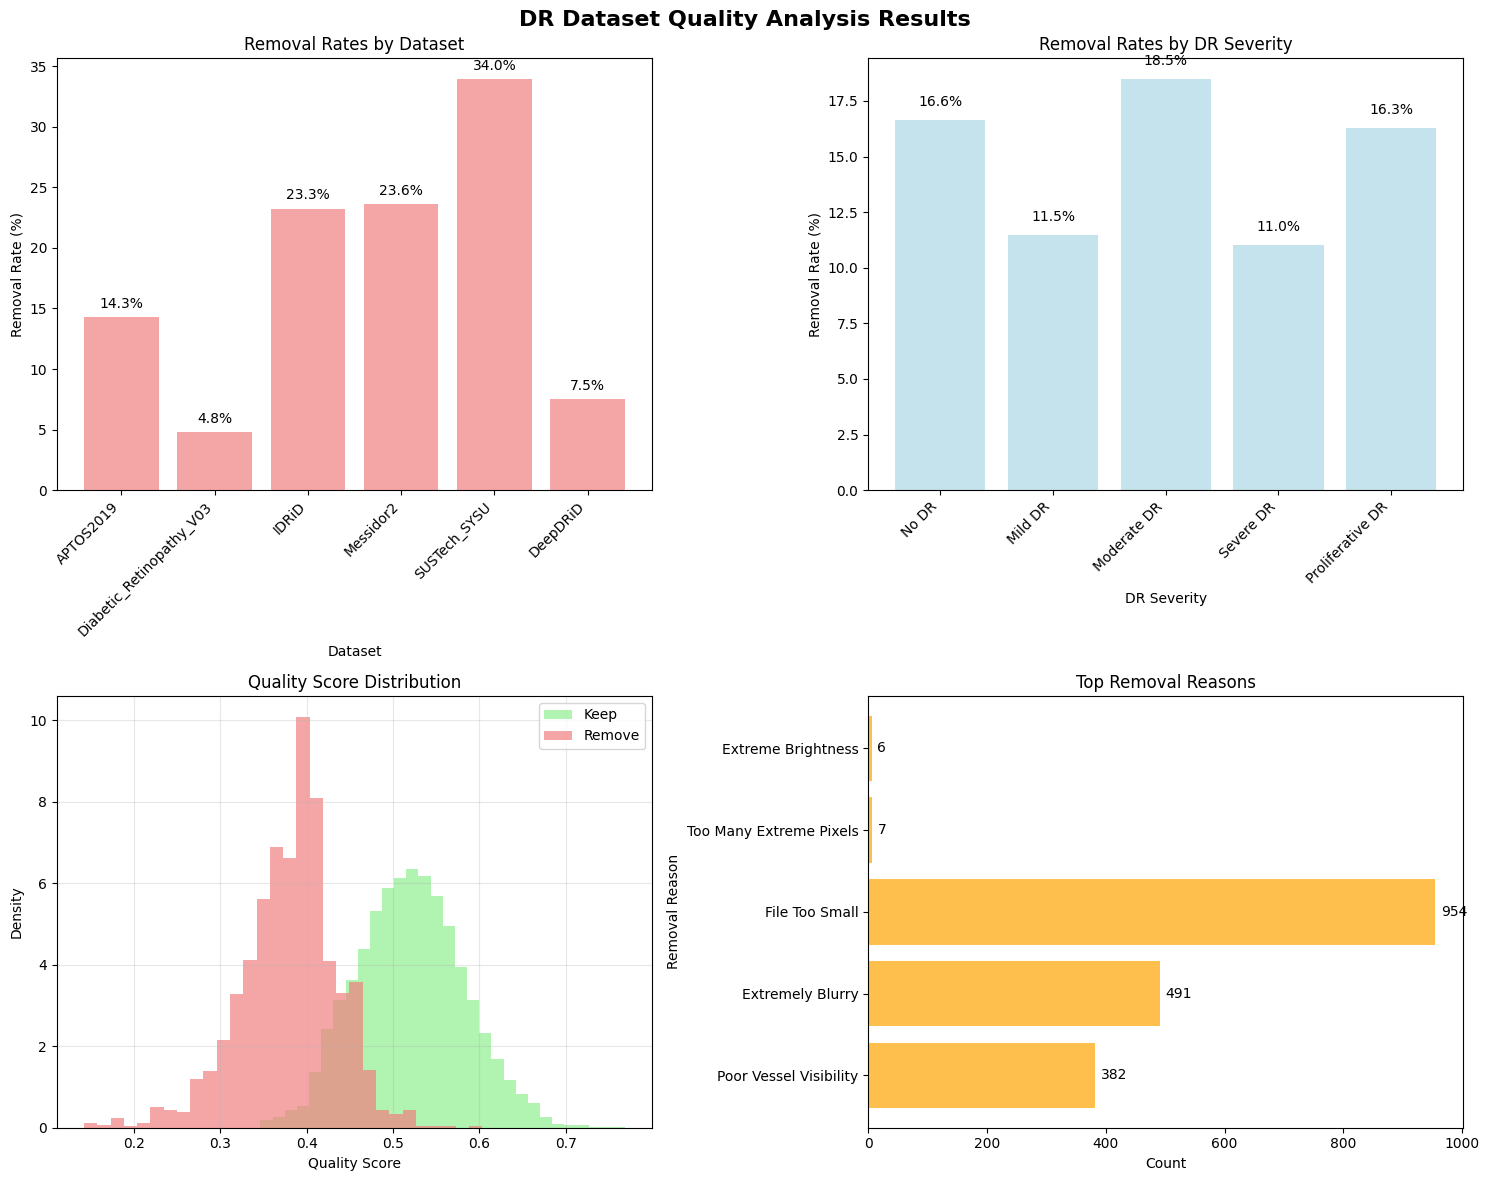

📊 Visualization saved to: quality_review/analysis_summary_plots.png


In [17]:
# ## 12. Optional: Quick Visualization

# In[12]:
# Create some basic visualizations if results are available
if 'all_results' in locals() and all_results:
    print("📊 Creating basic visualizations...")
    
    # Set up matplotlib
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('DR Dataset Quality Analysis Results', fontsize=16, fontweight='bold')
    
    df = pd.DataFrame(all_results)
    
    # 1. Removal rates by dataset
    ax1 = axes[0, 0]
    dataset_removal_rates = []
    dataset_names = []
    
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        removal_rate = len(dataset_data[dataset_data['recommended_action'] == 'REMOVE']) / len(dataset_data) * 100
        dataset_removal_rates.append(removal_rate)
        dataset_names.append(dataset)
    
    bars1 = ax1.bar(range(len(dataset_names)), dataset_removal_rates, color='lightcoral', alpha=0.7)
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Removal Rate (%)')
    ax1.set_title('Removal Rates by Dataset')
    ax1.set_xticks(range(len(dataset_names)))
    ax1.set_xticklabels(dataset_names, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, rate in zip(bars1, dataset_removal_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 2. Removal rates by DR class
    ax2 = axes[0, 1]
    dr_removal_rates = []
    dr_labels = []
    dr_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
    
    for dr_class in sorted(df['dr_severity'].unique()):
        dr_data = df[df['dr_severity'] == dr_class]
        removal_rate = len(dr_data[dr_data['recommended_action'] == 'REMOVE']) / len(dr_data) * 100
        dr_removal_rates.append(removal_rate)
        dr_label = dr_names[dr_class] if 0 <= dr_class < 5 else f'Class {dr_class}'
        dr_labels.append(dr_label)
    
    bars2 = ax2.bar(range(len(dr_labels)), dr_removal_rates, color='lightblue', alpha=0.7)
    ax2.set_xlabel('DR Severity')
    ax2.set_ylabel('Removal Rate (%)')
    ax2.set_title('Removal Rates by DR Severity')
    ax2.set_xticks(range(len(dr_labels)))
    ax2.set_xticklabels(dr_labels, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, rate in zip(bars2, dr_removal_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 3. Quality score distribution
    ax3 = axes[1, 0]
    keep_scores = df[df['recommended_action'] == 'KEEP']['overall_quality_score']
    remove_scores = df[df['recommended_action'] == 'REMOVE']['overall_quality_score']
    
    ax3.hist(keep_scores, bins=30, alpha=0.7, label='Keep', color='lightgreen', density=True)
    ax3.hist(remove_scores, bins=30, alpha=0.7, label='Remove', color='lightcoral', density=True)
    ax3.set_xlabel('Quality Score')
    ax3.set_ylabel('Density')
    ax3.set_title('Quality Score Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Top removal reasons
    ax4 = axes[1, 1]
    if 'removal_reasons_summary' in report:
        reasons = list(report['removal_reasons_summary'].keys())[:10]  # Top 10
        counts = [report['removal_reasons_summary'][reason] for reason in reasons]
        
        bars4 = ax4.barh(range(len(reasons)), counts, color='orange', alpha=0.7)
        ax4.set_ylabel('Removal Reason')
        ax4.set_xlabel('Count')
        ax4.set_title('Top Removal Reasons')
        ax4.set_yticks(range(len(reasons)))
        ax4.set_yticklabels([reason.replace('_', ' ').title() for reason in reasons])
        
        # Add value labels on bars
        for bar, count in zip(bars4, counts):
            width = bar.get_width()
            ax4.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2.,
                    f'{count}', ha='left', va='center')
    
    plt.tight_layout()
    
    # Save the plot
    plot_file = f'{OUTPUT_DIR}/analysis_summary_plots.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualization saved to: {plot_file}")

else:
    print("❌ Cannot create visualizations - no results available")


In [18]:
# ## 13. Final Checkpoint - Verification

# In[13]:
# Final verification that everything completed successfully
print("🔍 FINAL VERIFICATION:")
print("=" * 50)

# Check if all major components completed
checks = {
    'Valid datasets found': 'valid_datasets' in locals() and bool(valid_datasets),
    'Dataset profiles created': 'dataset_profiles' in locals() and bool(dataset_profiles),
    'Quality analysis completed': 'all_results' in locals() and bool(all_results),
    'Report generated': 'report' in locals() and bool(report),
    'Results saved': os.path.exists(f'{OUTPUT_DIR}/flagged_images_summary.csv'),
    'Sample images created': os.path.exists(f'{OUTPUT_DIR}/sample_images'),
    'Flagged samples created': os.path.exists(f'{OUTPUT_DIR}/flagged_samples')
}

all_good = True
for check_name, check_result in checks.items():
    status = "✅" if check_result else "❌"
    print(f"{status} {check_name}")
    if not check_result:
        all_good = False

if all_good:
    print(f"\n🎉 SUCCESS! All components completed successfully!")
    print(f"📁 Check the '{OUTPUT_DIR}' directory for all results.")
    
    if 'all_results' in locals():
        total = len(all_results)
        flagged = len([r for r in all_results if r['recommended_action'] == 'REMOVE'])
        print(f"📊 Final count: {flagged:,} of {total:,} images flagged for removal ({flagged/total*100:.1f}%)")
else:
    print(f"\n⚠️  Some components did not complete successfully.")
    print(f"Please review the error messages above and re-run the failed sections.")

print(f"\n📋 Remember: This analysis only IDENTIFIED potential issues.")
print(f"🚨 NO IMAGES WERE ACTUALLY REMOVED from your datasets!")
print(f"💡 Review the flagged samples before deciding on actual removal.")

🔍 FINAL VERIFICATION:
✅ Valid datasets found
✅ Dataset profiles created
✅ Quality analysis completed
✅ Report generated
✅ Results saved
✅ Sample images created
✅ Flagged samples created

🎉 SUCCESS! All components completed successfully!
📁 Check the 'quality_review' directory for all results.
📊 Final count: 1,690 of 10,578 images flagged for removal (16.0%)

📋 Remember: This analysis only IDENTIFIED potential issues.
🚨 NO IMAGES WERE ACTUALLY REMOVED from your datasets!
💡 Review the flagged samples before deciding on actual removal.


In [19]:
# Check what sample images were saved
import os
sample_base_dir = f'{identifier.output_dir}/sample_images'
print("📁 Sample images saved:")
for dataset_name in os.listdir(sample_base_dir):
    dataset_sample_dir = os.path.join(sample_base_dir, dataset_name)
    if os.path.isdir(dataset_sample_dir):
        num_samples = len([f for f in os.listdir(dataset_sample_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"   {dataset_name}: {num_samples} sample images in {dataset_sample_dir}")

📁 Sample images saved:
   APTOS2019: 20 sample images in quality_review/sample_images\APTOS2019
   DeepDRiD: 20 sample images in quality_review/sample_images\DeepDRiD
   Diabetic_Retinopathy_V03: 20 sample images in quality_review/sample_images\Diabetic_Retinopathy_V03
   IDRiD: 20 sample images in quality_review/sample_images\IDRiD
   Messidor2: 20 sample images in quality_review/sample_images\Messidor2
   SUSTech_SYSU: 20 sample images in quality_review/sample_images\SUSTech_SYSU


In [24]:
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def find_and_review_problematic_images(identifier, dataset_profiles,
                                     review_dir='problematic_images_review_all'):
    """Find and organize problematic images for manual review"""
    
    # Create review directory
    os.makedirs(review_dir, exist_ok=True)
    
    print("🔍 Finding problematic images based on quality thresholds...")
    
    for dataset_name, profile in dataset_profiles.items():
        print(f"\n📂 Processing {dataset_name}...")
        
        # Get adaptive thresholds for this dataset
        thresholds = profile['adaptive_thresholds']
        
        # Create subdirectories for this dataset
        dataset_review_dir = os.path.join(review_dir, dataset_name)
        os.makedirs(dataset_review_dir, exist_ok=True)
        
        # Analyze all images in the dataset
        dataset_path = valid_datasets[dataset_name]
        all_images = []
        
        # Collect all images from ALL subdirectories (all DR severity levels)
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    all_images.append(os.path.join(root, file))
        
        print(f"   🔍 Analyzing {len(all_images)} images...")
        
        problematic_by_severity = {0: [], 1: [], 2: [], 3: [], 4: []}
        
        # Analyze each image
        for i, img_path in enumerate(all_images):
            if i % 500 == 0 and i > 0:
                print(f"      Progress: {i}/{len(all_images)} ({i/len(all_images)*100:.1f}%)")
            
            try:
                # Get image characteristics
                char = identifier.analyze_single_image(img_path)
                if not char:
                    continue
                
                # Calculate quality score (same logic as in profiling)
                brightness = float(char['brightness']) if char['brightness'] is not None else 127.5
                contrast = float(char['contrast']) if char['contrast'] is not None else 50.0
                sharpness = float(char['sharpness']) if char['sharpness'] is not None else 500.0
                entropy = float(char['entropy']) if char['entropy'] is not None else 4.0
                illumination_uniformity = float(char['illumination_uniformity']) if char['illumination_uniformity'] is not None else 0.5
                vessel_visibility = float(char['vessel_visibility']) if char['vessel_visibility'] is not None else 0.1
                optic_disc_visibility = float(char['optic_disc_visibility']) if char['optic_disc_visibility'] is not None else 0.1
                
                # Normalize metrics
                brightness_norm = min(1.0, max(0.0, brightness / 255.0))
                contrast_norm = min(1.0, max(0.0, contrast / 100.0))
                sharpness_norm = min(1.0, max(0.0, sharpness / 1000.0))
                entropy_norm = min(1.0, max(0.0, entropy / 8.0))
                
                basic_quality = np.mean([brightness_norm, contrast_norm, sharpness_norm, entropy_norm])
                medical_quality = np.mean([
                    illumination_uniformity,
                    min(1.0, vessel_visibility * 10),
                    min(1.0, optic_disc_visibility * 10)
                ])
                
                combined_quality = 0.3 * basic_quality + 0.7 * medical_quality
                
                # Determine DR severity from path or filename
                dr_severity = get_dr_severity_from_path(img_path)
                
                # Check if image is below threshold for its DR severity
                if dr_severity in thresholds and combined_quality < thresholds[dr_severity]:
                    problematic_by_severity[dr_severity].append({
                        'path': img_path,
                        'quality_score': combined_quality,
                        'threshold': thresholds[dr_severity],
                        'characteristics': char
                    })
            
            except Exception as e:
                print(f"      ⚠️  Error analyzing {img_path}: {e}")
                continue
        
        # Save problematic images by severity
        total_problematic = 0
        for severity, images in problematic_by_severity.items():
            if images:
                severity_dir = os.path.join(dataset_review_dir, f'DR_severity_{severity}')
                os.makedirs(severity_dir, exist_ok=True)
                
                # Sort by quality score (worst first)
                images.sort(key=lambda x: x['quality_score'])
                
                print(f"   📋 DR Severity {severity}: {len(images)} problematic images")
                
                # Copy worst 50 images for manual review
                for i, img_info in enumerate(images[:50]):
                    try:
                        src_path = img_info['path']
                        dst_name = f"quality_{img_info['quality_score']:.3f}_{os.path.basename(src_path)}"
                        dst_path = os.path.join(severity_dir, dst_name)
                        shutil.copy2(src_path, dst_path)
                        
                        # Save characteristics as text file
                        txt_path = dst_path.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
                        with open(txt_path, 'w') as f:
                            f.write(f"Quality Score: {img_info['quality_score']:.3f}\n")
                            f.write(f"Threshold: {img_info['threshold']:.3f}\n")
                            f.write(f"Original Path: {src_path}\n\n")
                            f.write("Characteristics:\n")
                            for key, value in img_info['characteristics'].items():
                                f.write(f"  {key}: {value}\n")
                    
                    except Exception as e:
                        print(f"      ⚠️  Error copying {src_path}: {e}")
                
                total_problematic += len(images)
        
        print(f"   ✅ Found {total_problematic} total problematic images in {dataset_name}")
        print(f"   📁 Review images saved to: {dataset_review_dir}")
    
    print(f"\n🎯 Review complete! Check the '{review_dir}' directory")

def get_dr_severity_from_path(img_path):
    """Extract DR severity from image path or filename - improved version"""
    import re
    path_lower = img_path.lower()
    
    # First, check for direct folder patterns like /0/, /1/, /2/, /3/, /4/
    folder_match = re.search(r'[/\\]([0-4])[/\\]', img_path)
    if folder_match:
        return int(folder_match.group(1))
    
    # Check for keyword-based patterns
    if 'no_dr' in path_lower or 'grade_0' in path_lower or '_0_' in path_lower:
        return 0
    elif 'mild' in path_lower or 'grade_1' in path_lower or '_1_' in path_lower:
        return 1
    elif 'moderate' in path_lower or 'grade_2' in path_lower or '_2_' in path_lower:
        return 2
    elif 'severe' in path_lower or 'grade_3' in path_lower or '_3_' in path_lower:
        return 3
    elif 'proliferative' in path_lower or 'grade_4' in path_lower or '_4_' in path_lower:
        return 4
    
    # Look for patterns like "grade_2", "severity_1", etc.
    grade_match = re.search(r'grade[_\-]?([0-4])', path_lower)
    if grade_match:
        return int(grade_match.group(1))
    
    severity_match = re.search(r'severity[_\-]?([0-4])', path_lower)
    if severity_match:
        return int(severity_match.group(1))
    
    # Look for numeric patterns in filename
    filename_match = re.search(r'[_\-]([0-4])[_\-\.]', path_lower)
    if filename_match:
        return int(filename_match.group(1))
    
    # Default to 0 if can't determine
    print(f"   ⚠️  Could not determine DR severity for: {img_path}")
    return 0

def create_review_html(review_dir='problematic_images_review_all'):
    """Create an HTML file for easy image review"""
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Problematic Images Review</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .dataset { margin-bottom: 30px; border: 1px solid #ccc; padding: 15px; }
            .severity { margin-bottom: 20px; }
            .image-grid { display: grid; grid-template-columns: repeat(auto-fill, minmax(200px, 1fr)); gap: 10px; }
            .image-item { border: 1px solid #ddd; padding: 10px; text-align: center; }
            .image-item img { max-width: 100%; height: 150px; object-fit: cover; }
            .quality-score { font-weight: bold; color: red; }
        </style>
    </head>
    <body>
        <h1>Problematic Images Review</h1>
    """
    
    for dataset_name in os.listdir(review_dir):
        dataset_path = os.path.join(review_dir, dataset_name)
        if not os.path.isdir(dataset_path):
            continue
        
        html_content += f'<div class="dataset"><h2>{dataset_name}</h2>'
        
        for severity_dir in sorted(os.listdir(dataset_path)):
            severity_path = os.path.join(dataset_path, severity_dir)
            if not os.path.isdir(severity_path):
                continue
            
            html_content += f'<div class="severity"><h3>{severity_dir}</h3><div class="image-grid">'
            
            images = [f for f in os.listdir(severity_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for img_file in sorted(images)[:20]:  # Show first 20
                quality_score = img_file.split('_')[1] if '_' in img_file else 'unknown'
                img_rel_path = os.path.join(dataset_name, severity_dir, img_file).replace('\\', '/')
                
                html_content += f'''
                <div class="image-item">
                    <img src="{img_rel_path}" alt="{img_file}">
                    <div class="quality-score">Quality: {quality_score}</div>
                    <div>{img_file}</div>
                </div>
                '''
            
            html_content += '</div></div>'
        
        html_content += '</div>'
    
    html_content += '</body></html>'
    
    html_path = os.path.join(review_dir, 'review.html')
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"📄 HTML review file created: {html_path}")
    print("   Open this file in your web browser to easily review problematic images")

# Run the analysis
print("🚀 Starting problematic image identification...")
find_and_review_problematic_images(identifier, dataset_profiles)

# Create HTML review file
create_review_html()

print("\n✅ Review setup complete!")
print("\nTo review the images:")
print("1. Check the 'problematic_images_review_all' directory")
print("2. Open 'problematic_images_review_all/review.html' in your web browser")
print("3. Each image has a quality score and characteristics file (.txt)")

🚀 Starting problematic image identification...
🔍 Finding problematic images based on quality thresholds...

📂 Processing APTOS2019...
   🔍 Analyzing 3662 images...
      Progress: 500/3662 (13.7%)
      Progress: 1000/3662 (27.3%)
      Progress: 1500/3662 (41.0%)
      Progress: 2000/3662 (54.6%)
      Progress: 2500/3662 (68.3%)
      Progress: 3000/3662 (81.9%)
      Progress: 3500/3662 (95.6%)
   📋 DR Severity 0: 346 problematic images
   📋 DR Severity 1: 24 problematic images
   📋 DR Severity 2: 97 problematic images
   📋 DR Severity 3: 12 problematic images
   📋 DR Severity 4: 15 problematic images
   ✅ Found 494 total problematic images in APTOS2019
   📁 Review images saved to: problematic_images_review_all\APTOS2019

📂 Processing Diabetic_Retinopathy_V03...
   🔍 Analyzing 1437 images...
      Progress: 500/1437 (34.8%)
      Progress: 1000/1437 (69.6%)
   📋 DR Severity 0: 63 problematic images
   📋 DR Severity 1: 1 problematic images
   📋 DR Severity 2: 10 problematic images
  